In [7]:
! pip install \
    pandas \
    matplotlib \
    statsmodels

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.formula.api import ols

LOGS_PATH = 'tmp/logs_2025-09-04_16-09-13.csv'

In [9]:
df_logs = pd.read_csv(LOGS_PATH, parse_dates=['timestamp'])
print(df_logs.shape)
df_logs.sample(1).T.to_dict()

(465750, 9)


{279930: {'timestamp': '2025-09-04 12:46:44.344000+00:00',
  'tasks': '1-2-5',
  'batch_id': 108,
  'processed_%': 86.4,
  'seconds': 2.154,
  'dag_id': 6,
  'task_type': 'extractors',
  'run_id': '02f66ec1-3edf-4ec5-8f4c-121276271142',
  'task_id': 1}}

In [15]:
cols = ['extractors', 'transformers', 'loaders']
df_time_span = (
    df_logs
    .groupby(['run_id', 'task_type', 'tasks'])['timestamp']
    .agg(start_time='min', end_time='max')
    .reset_index()
)
df_time_span['start_time'] = pd.to_datetime(
    df_time_span['start_time'], errors='coerce')
df_time_span['end_time'] = pd.to_datetime(
    df_time_span['end_time'], errors='coerce')
df_time_span['duration'] = (
    df_time_span['end_time'] - df_time_span['start_time']
).dt.total_seconds()
df_time_span

,run_id,task_type,tasks,start_time,end_time,duration
0,004c9b2b-a7e3-4cc8-9195-516daf52a991,extractors,2-2-5,2025-09-04 13:13:07.935000+00:00,2025-09-04 13:15:22.147000+00:00,134.212
1,004c9b2b-a7e3-4cc8-9195-516daf52a991,loaders,2-2-5,2025-09-04 13:12:49.026000+00:00,2025-09-04 13:14:00.205000+00:00,71.179
2,004c9b2b-a7e3-4cc8-9195-516daf52a991,transformers,2-2-5,2025-09-04 13:12:51.729000+00:00,2025-09-04 13:16:54.384000+00:00,242.655
3,006d70da-76ac-4e72-9d7c-4245b29c99b9,extractors,3-4-3,2025-09-04 15:04:14.369000+00:00,2025-09-04 15:05:39.407000+00:00,85.038
4,006d70da-76ac-4e72-9d7c-4245b29c99b9,loaders,3-4-3,2025-09-04 15:04:14.366000+00:00,2025-09-04 15:05:42.638000+00:00,88.272
...,...,...,...,...,...,...
3745,ffb1cafc-0ba6-4b2f-a812-91ca21ba21da,loaders,1-2-1,2025-09-04 14:21:37.345000+00:00,2025-09-04 14:26:00.162000+00:00,262.817
3746,ffb1cafc-0ba6-4b2f-a812-91ca21ba21da,transformers,1-2-1,2025-09-04 14:21:39.134000+00:00,2025-09-04 14:25:29.719000+00:00,230.585
3747,ffd88ab6-fe8c-423c-9645-3c50e52fc892,extractors,3-4-4,2025-09-04 13:44:56.116000+00:00,2025-09-04 13:46:37.329000+00:00,101.213
3748,ffd88ab6-fe8c-423c-9645-3c50e52fc892,loaders,3-4-4,2025-09-04 13:44:52.332000+00:00,2025-09-04 13:46:08.958000+00:00,76.626


In [18]:
df_mean = (
    df_time_span
    .groupby(['task_type', 'tasks'])['duration']
    .mean()
    .reset_index()
)
df_mean

,task_type,tasks,duration
0,extractors,1-1-1,262.5153
1,extractors,1-1-2,262.5996
2,extractors,1-1-3,263.2961
3,extractors,1-1-4,262.2292
4,extractors,1-1-5,259.3800
...,...,...,...
370,transformers,5-5-1,98.8060
371,transformers,5-5-2,104.9749
372,transformers,5-5-3,113.3648
373,transformers,5-5-4,112.5792


In [20]:
df_grouped = (
    df_mean
    .pivot(index='tasks', columns='task_type', values='duration')
    .fillna(0)
    .reset_index()
)
df_grouped['total_pipeline_time'] = df_grouped[cols].max(axis=1)
df_grouped

task_type,tasks,extractors,loaders,transformers,total_pipeline_time
0,1-1-1,262.5153,260.5113,462.3864,462.3864
1,1-1-2,262.5996,129.9525,460.7849,460.7849
2,1-1-3,263.2961,99.4761,459.0465,459.0465
3,1-1-4,262.2292,68.4998,460.5868,460.5868
4,1-1-5,259.3800,54.4600,460.9882,460.9882
...,...,...,...,...,...
120,5-5-1,59.7001,260.1056,98.8060,260.1056
121,5-5-2,63.3140,134.5012,104.9749,134.5012
122,5-5-3,64.5917,95.7003,113.3648,113.3648
123,5-5-4,68.8815,75.0968,112.5792,112.5792


In [21]:
result = df_grouped.copy()
result['etl_variance'] = round(result[cols].var(axis=1), 3)
result['batches_rate'] = round(125 / result['total_pipeline_time'], 2)
result.sort_values(by='batches_rate', inplace=True)
result

task_type,tasks,extractors,loaders,transformers,total_pipeline_time,etl_variance,batches_rate
0,1-1-1,262.5153,260.5113,462.3864,462.3864,13451.005,0.27
1,1-1-2,262.5996,129.9525,460.7849,460.7849,27720.457,0.27
2,1-1-3,263.2961,99.4761,459.0465,459.0465,32407.681,0.27
3,1-1-4,262.2292,68.4998,460.5868,460.5868,38434.839,0.27
4,1-1-5,259.3800,54.4600,460.9882,460.9882,41317.208,0.27
...,...,...,...,...,...,...,...
123,5-5-4,68.8815,75.0968,112.5792,112.5792,558.842,1.11
73,3-5-4,96.1199,82.9956,111.4703,111.4703,203.115,1.12
97,4-5-3,76.3412,99.7800,110.7558,110.7558,309.035,1.13
124,5-5-5,74.3416,74.5062,108.6534,108.6534,390.560,1.15


In [22]:
result.sample(1).T.to_dict()

{28: {'tasks': '2-1-4',
  'extractors': 136.664,
  'loaders': 90.5241,
  'transformers': 459.0517,
  'total_pipeline_time': 459.0517,
  'etl_variance': 40312.552,
  'batches_rate': 0.27}}

In [23]:
df_111 = result.copy()[result['tasks'] == '1-1-1']
sequential_time = sum([df_111[c].values[0] for c in cols])
result['sequential_time'] = sequential_time
print(sequential_time, 'seconds')

985.4129999999999 seconds


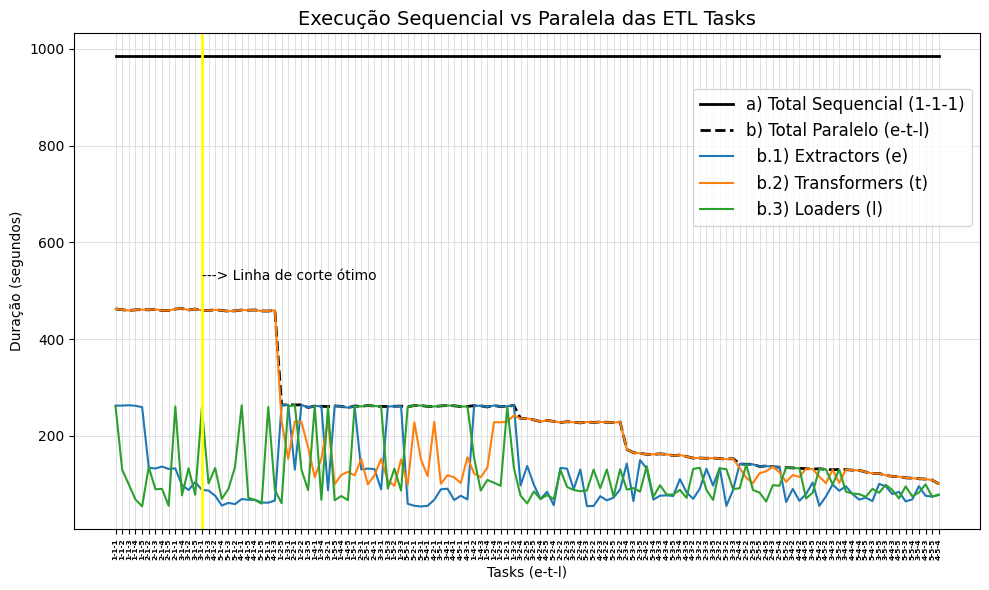

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(result['tasks'], result['sequential_time'], 
         label='a) Total Sequencial (1-1-1)', color='black', linewidth=2)
plt.plot(result['tasks'], result['total_pipeline_time'], 
         label='b) Total Paralelo (e-t-l)', 
         color='black', linestyle='--', linewidth=2)
plt.plot(result['tasks'], 
         result['extractors'], 
         label='  b.1) Extractors (e)')
plt.plot(result['tasks'], 
         result['transformers'], 
         label='  b.2) Transformers (t)')
plt.plot(result['tasks'], 
         result['loaders'], 
         label='  b.3) Loaders (l)')
offset = (result['total_pipeline_time'].max() 
          - result['total_pipeline_time'].min()) * 0.06
# for i, txt in enumerate(result['batches_rate']):
#     plt.text(result['tasks'].iloc[i], 
#              result['total_pipeline_time'].iloc[i] + offset, 
#              f'{txt} b/s', rotation=90, fontsize=10, ha='center',
#              bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.xlabel('Tasks (e-t-l)')
plt.ylabel('Duração (segundos)')
plt.title('Execução Sequencial vs Paralela das ETL Tasks', fontsize=14)
plt.xticks(rotation=90, fontsize=5.4, fontweight="bold")
plt.axvline(x=13, color='yellow', linewidth=2)
ymax = plt.ylim()[1]
plt.text(13, ymax * 0.5, '---> Linha de corte ótimo', color='black', 
         va='bottom', ha='left', fontsize=10)
plt.legend(fontsize=12, loc='center right', bbox_to_anchor=(1, 0.75))
plt.tight_layout()
plt.grid(color='lightgray', linewidth=0.5)
plt.show()

In [29]:
result[result['batches_rate'] > 1]\
    [['total_pipeline_time', 'tasks', 'batches_rate']]\
        .sort_values(by='batches_rate', ascending=False).reset_index(drop=True)

task_type,total_pipeline_time,tasks,batches_rate
0,100.9232,4-5-4,1.24
1,108.6534,5-5-5,1.15
2,110.7558,4-5-3,1.13
3,111.4703,3-5-4,1.12
4,112.5792,5-5-4,1.11
5,113.3648,5-5-3,1.10
6,115.8237,4-5-5,1.08
7,116.3860,4-4-3,1.07
8,118.4597,3-5-3,1.06
9,122.5608,3-5-5,1.02


In [25]:
result["tasks"] = result["tasks"].astype("category") 

model_time = ols("total_pipeline_time ~ C(tasks)", data=result).fit()
anova_time = sm.stats.anova_lm(model_time, typ=2)
print(anova_time)


model_rate = ols("batches_rate ~ C(tasks)", data=result).fit()
anova_rate = sm.stats.anova_lm(model_rate, typ=2)
print(anova_rate)

/opt/conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:1543: RuntimeWarning: invalid value encountered in dot
  tmp = dot_fun(r_matrix, dot_fun(cov_p, np.transpose(other)))


ValueError: r_matrix performs f_test for using dimensions that are asymptotically non-normal